# Action Balance Equation Fenics Test Notebook
## $\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_y N}{\partial y} +  \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$



## Uniform coastline:

Assuming coast line that varies along x direction but is uniform in y, mathematically meaning:

$\frac{\partial N}{\partial y} = 0$ and $\frac{\partial c_{y}}{\partial y} = 0$

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$

In this specific script we will perform the test as seen in ONR test bed case A21

## Case A21

"An infinitely long plane beach with parallel depth contours (slope 1:200) is considered. The x-axis is normal to the depth contours (see Figure 7). At a water depth of 20m, monochromatic, uni- directional waves enter the model area. At the up-wave boundary the incoming waves propagate at an angle of 0° relative to the positive x-axis. The distance of the up-wave boundary to the waterline is 4000 m. The incident wave height Hi and period Ti are 1 m and 10 s respectively.
Ambient currents and wind are absent."

## Conditions
In the SWAN computation this harmonic wave is simulated with a Gaussian-shaped frequency spectrum with peak
frequency 0.1 Hz, standard deviation 0.01 Hz, and a resolution
of 3% of the frequency (diffusion in frequency space does not
occur as $c_{\sigma}$= 0 in this case, and the frequency resolution may
therefore be somewhat coarse). The long crestedness in this
computation is simulated with a $cos^{500} (\theta)$ directional distribution (the directional width $\sigma_{\theta} = 2.5 $ degrees, where su is the standard
deviation of the directional distribution



## Solution

$\frac{H^2}{H_i^2}=\frac{c_{g,i}cos(\theta_i)}{c_g cos(\theta)}$

Where $H_i$ , $c_{g,i}$, $\theta_i$ is the boundary condition that remains steady through time

In [10]:
#import any necessary libraries in this block
from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import interpolate as interp
from scipy import integrate as integrate
from ufl import nabla_div
#from mayavi import mlab
%matplotlib inline
#define global variables
g=9.81

In [11]:
#all functions necessary to run this test case
#this expression requires sigma to be in second index
def Gauss_Expression_1D(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3)',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak)
    return E

def Gauss_Expression_IC(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    tol=1e-14
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('x[0] < tol ? aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3): 0',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak,tol=tol)
    return E
#an Expression class to evaluate u(x,y) on the 1D domain (range y, x fixed)
#maybe modify so input can determine if we want range y (fixed x) or range x (fixed y)
#this case want space to be x, sigma to be y
class my1DExpression(UserExpression):
    def __init__(self,u_2d,x,**kwargs):
        super().__init__(**kwargs)
        self.u_2d=u_2d
        self.x=x
        #Expression.__init__(self)
        self._vx= np.array([0.])
        self._pt_x= np.array([0.,0.])
    def eval(self, values, x):
        self._pt_x[0]= self.x
        self._pt_x[1]= x[0]
        self.u_2d.eval(self._vx,self._pt_x)
        values[0] = self._vx[0]
        
#need a function to calculate wave speed (phase and group) and wavenumber
def swan_calc_wavespeeds_k(sigmas,depths,g=9.81):
    #taken from Jessica's code
    cg_out=np.zeros(len(sigmas))
    k_out=np.zeros(len(sigmas))
    WGD=np.sqrt(depths/g)*g
    SND=sigmas*np.sqrt(depths/g)
    
    shallow_range=np.argwhere(SND<1e-6)
    mid_range=np.argwhere((SND<2.5)&(SND>=1e-6))
    deep_range=np.argwhere(SND>=2.5)
    
    def cg_mid(SND,g,depths,sigmas):
        SND2=SND*SND
        C=np.sqrt(g*depths/(SND2 +1/(1+0.666*SND2+.445*SND2**2 
                                     - 0.105*SND2**3 + 0.272*SND2**4)))
        KND=sigmas*depths/C
        
        FAC1=2*KND/np.sinh(2*KND)
        N=0.5*(1+FAC1)
        return N*C,sigmas/C
    def cg_deep(g,sigmas):
        return 0.5*g/sigmas
    def cg_shallow(WGD):
        return WGD

    cg_out[shallow_range]=cg_shallow(WGD[shallow_range])
    k_out[shallow_range]=SND[shallow_range]/depths[shallow_range]
    cg_out[mid_range],k_out[mid_range]=cg_mid(SND[mid_range],g,depths[mid_range],sigmas[mid_range])
    cg_out[deep_range]=cg_deep(g,sigmas[deep_range])
    k_out[deep_range]=sigmas[deep_range]**2/g

    return cg_out,k_out

def calc_c_sigma(sigmas,k,depths,c_g,currents,z_coords,loc_num):
    ##Inputs
    #sigmas - takes in a vector of sigma values (sigma coordinate at each d.o.f) at one point in physical spaxe
    #thetas
    #k - wavenumber corresponding to the given sigmas and thetas
    #c_g - corresponding group velocity
    #(note sigmas, thetas,k,c_g should all be same length which is number of d.o.f in one 2D slice)
    #depths - depths in meters of ALL physical coordinates (not just current one)
    #z_coords - unique coordinates in physical space (not just current one)
    #currents - water velocity at ALL physical coordinates
    #loc_num - the number of the physical point (starts at 0)
    #(note depths,z_coords,currents should all be same length which is the number of unique points in physical space)
    ##Outputs
    #outputs a vector same size as sigmas that is the c_sigma at all d.o.f in ONE 2D slice 
    #of the 3D domain corresponding to a single point in physical space for c_theta and c_sigma
    
    #for now assuming H is constant in time but can fix this later
    dHdt=0.0
    dHdy = 0.0
    dudy = 0.0
    dvdx = 0.0 #migh not have to be 0, well see
    dvdy = 0.0
    
    #also going to assume v is zero but maybe can change this later
    v=0.0
    u=0.0#currents[loc_num]
    H=depths#[loc_num]
    #calc gradient of H w.r.t. x
    #this is just forward euler but only works for fixed geometry
    #instead we'll hard code for this case
    dHdx=-1.0/200.0
    dudx=0.0
    '''
    if loc_num == 0:
        dHdx =(depths[loc_num+1]-H)/(z_coords[loc_num+1]-z_coords[loc_num])
        dudx = (currents[loc_num+1]-u)/(z_coords[loc_num+1]-z_coords[loc_num])
    elif loc_num == len(z_coords)-1:
        dHdx = (H-depths[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
        dudx = (u-currents[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
    else:
        dHdx = (depths[loc_num+1]-depths[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
        dudx = (currents[loc_num+1]-currents[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
    '''
    
    #now calculate velocity vectors
    c_sigma = k*sigmas/(np.sinh(2*k*H)) *(dHdt + u*dHdx + v*dHdy) - c_g*k*(dudx)
    #c_theta = sigmas/(np.sinh(2*k*H))*(dHdx*np.sin(thetas)- dHdy*np.cos(thetas)) + \
    #    dudx*np.cos(thetas)*np.sin(thetas) - dudy*(np.cos(thetas)**2) + dvdx*(np.sin(thetas)**2) \
    #    -dvdy*np.cos(thetas)*np.sin(thetas)
    return c_sigma #,c_theta


In [33]:
#function that generates the weak form
def gen_weakform(mesh,WeakForm,TimeStep,V,u_n,c,dt,S = Constant(0),p_degree=4):
    #Inputs:
    #mesh is the domain
    #WeakForm is string representing the variational formulation
    #V is solution space that should be chosen
    #u_D are dirichlet boundary conditions as an expression
    #p_degree is the degree expressions will be approximated to
    #wave speed c should be a function
    
    #Outputs:
    #entire weak form as F
    #boundary condition as bc
    #initial condition as u_n (necessary for time stepping)
    
    #Define source term, boundary, and wave propogation depending on test case choice
    u = TrialFunction(V)
    v = TestFunction(V)



    #if WeakForm == 'Galerkin':
        #bc = DirichletBC(V, u_n, boundary,"geometric")
    #else:
        #bc = DirichletBC(V, u_n, boundary)
  
    
    

    if WeakForm == 'LSQ':
        #Least Squares bilinear form
        #(Au, Av) = (f, Av) <==> (Au-f,Av) = 0
    
        if TimeStep == 'Implicit_Euler':
            #Implicit Euler
            n=FacetNormal(mesh)
            dof_coordinates=V.tabulate_dof_coordinates()
            n_dof=V.dim()
            d=mesh.geometry().dim()
            dof_coordinates.resize((n_dof,d))
            x = dof_coordinates[:,0]
            X_right = max(x)
            x, y = SpatialCoordinate(mesh)
            Gamma_right = conditional(x > X_right-1e-14, 1,0)
            F=(inner(u + dt*nabla_div(c*u) - u_n - dt*S, v + dt*nabla_div(c*v) ))*dx + dt*inner(u*dot(c,n), v)*Gamma_right*ds
        elif TimeStep == 'Trap_Rule':
            #Trap Rule
            F = (inner(u + 0.5*dt*nabla_div(c*u) + 0.5*dt*nabla_div(c*u_n) - u_n -dt*S, v + 0.5*dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Explicit_Euler':
            #Explicit Euler
            F = (inner(u+dt*nabla_div(c*u_n) - u_n - dt*S, v))*dx

    elif WeakForm == 'DG':
        #continuous galerkin bilinearr form
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            cn=(dot(c,n) + abs(dot(c,n)))/2
            #F= inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner(cn('+')*u('+')-cn('-')*u('-'),jump(v))*dS + dt*inner(u*cn,v)*ds
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + dt*inner( u*dot(c,n), v )*ds
    elif WeakForm == 'SUPG':
        if TimeStep == 'Implicit_Euler':
            hmax=mesh.hmax()
            #h=Constant(5)
            #tau=Expression('pow(sqrt(yn*yn+ym*ym+yz*yz)/hh,-1)', degree=p_degree ,  domain=mesh, yn=1 , ym=1,yz=1 , hh=hmax)
            #tau=Expression('0',degree=1)
            tau=hmax/dot(c,c)**0.5
            n=FacetNormal(mesh)
            F = inner(u - dt*S -u_n,v)*dx - dt*(inner(c*u,grad(v)))*dx + dt*inner(u*dot(c,n), v)*ds + inner(u+dt*nabla_div(c*u) 
                                                                               - dt*S - u_n, tau*nabla_div(c*v))*dx
    elif WeakForm == 'Galerkin':
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner(u*dot(c,n), v)*ds
    return F




In [39]:
#Run coastal from scratch
#determine spectral domain
omega_min=0.25 #smallest rad. frequency (needs to be larger than 0)
omega_max = 2.0 #largest rad. frequency
n_sigma = 30 #number of elements in frequncy which is dimension no. 0   
#should be 4000 (need to truncate a bit due to problem at 0 elevation)
n_space=100 #number of elements along coastline
space_len=3950 #distance of physical domain in meters

#create mesh, should only need 2d. no theta or second space dimension necessary
mesh1=RectangleMesh(Point(0,omega_min),Point(space_len,omega_max),n_space,n_sigma)

#Build FEM spcace
#select degree/type of basis function
pq_degree = 1 #degree of basis functions
p_type = 'P' #P for polynomial, CG for continuous Galerkin, DG for disc. galerkin (only if using DG weakform)
WeakForm='SUPG' #SUPG, Galerkin,DG or LSQ

V = FunctionSpace(mesh1, p_type , pq_degree)

#plot(mesh1)


In [40]:
#explore d.o.f
#we need to extract d.o.f coordinates because we define wave properties pointwise
#(can maybe do expressions but very messy)
dof_coordinates=V.tabulate_dof_coordinates()

n=V.dim()
d=mesh1.geometry().dim()
dof_coordinates.resize((n,d))

#dof_x=dof_coordinates[:,0] #these are the coordinates in space
#dof_y = dof_coordinates[:,1] #these are rel. radian freq i think
#for some reason above is giving problems so try this for now
#this could be debug if needed
#dof_x=np.array(interpolate(Expression('x[0]',degree=1),V).vector())
#dof_y=np.array(interpolate(Expression('x[1]',degree=1),V).vector())
#dof_z=np.array(interpolate(Expression('x[2]',degree=1),V).vector())

lats = dof_coordinates[:,0] #dof in space
sigmas = dof_coordinates[:,1] #dof in frequency


#calculate depths for  this test case
depths=20-lats/200


#initial/boundary conditions (for now, GAUSS only)
F_peak=0.1
F_std=0.1
HS=1



T=2000
num_steps=200
dt=T/num_steps


#we want to assign dof to a fenics function
#convert numpy vector into fenics variable
C1 = Function(V)
C2 = Function(V)
S=Function(V)

ctr=0


#current in m/s at each coordinate, for now steady in time, positive toward coast
currents = np.zeros(depths.shape)
lat_coords=np.unique(lats)



#for DG we can't split into slices like above so we'll need to figure something out
#calculate group velocities and wavenumbers pointwise
c_g,k=swan_calc_wavespeeds_k(sigmas,depths,g=9.81)

#k[np.isnan(k)] = 0

c_sigmas=calc_c_sigma(sigmas,k,depths,c_g,currents,lat_coords,ctr)

#c_sigmas[np.isnan(c_sigmas)] = 0
#c_thetas[np.isnan(c_thetas)] = 0
#assign pointwise values to FEniCS function
C2.vector()[:]=c_sigmas
C1.vector()[:]=c_g

#now assign initial condition
B=Gauss_Expression_IC(F_peak,F_std,HS)
u_n=interpolate(B,V)

#probably redundant
#S=interpolate(S,V)
#C_SIG=interpolate(C1,V)
#C_THET=interpolate(C2,V)
#C_X=interpolate(C3,V)

c= as_vector([C1,C2])
#c=Constant((0.0,0.0,0.0))
F=gen_weakform(mesh1,WeakForm,'Implicit_Euler',V,u_n,c,dt,S=Constant(0),p_degree=4)
print(lat_coords)
print(depths)



[    0.     39.5    79.    118.5   158.    197.5   237.    276.5   316.
   355.5   395.    434.5   474.    513.5   553.    592.5   632.    671.5
   711.    750.5   790.    829.5   869.    908.5   948.    987.5  1027.
  1066.5  1106.   1145.5  1185.   1224.5  1264.   1303.5  1343.   1382.5
  1422.   1461.5  1501.   1540.5  1580.   1619.5  1659.   1698.5  1738.
  1777.5  1817.   1856.5  1896.   1935.5  1975.   2014.5  2054.   2093.5
  2133.   2172.5  2212.   2251.5  2291.   2330.5  2370.   2409.5  2449.
  2488.5  2528.   2567.5  2607.   2646.5  2686.   2725.5  2765.   2804.5
  2844.   2883.5  2923.   2962.5  3002.   3041.5  3081.   3120.5  3160.
  3199.5  3239.   3278.5  3318.   3357.5  3397.   3436.5  3476.   3515.5
  3555.   3594.5  3634.   3673.5  3713.   3752.5  3792.   3831.5  3871.
  3910.5  3950. ]
[ 20.      20.      19.8025 ...,   0.4475   0.25     0.25  ]


In [41]:
#attempt to figure out b.c.
def incoming_boundary(x,on_boundary):
    
    return on_boundary and (near(x[0],0, 1e-14))

def other_boundary(x,on_boundary):
    
    return on_boundary and not (near(x[0],0, 1e-14))


def whole_boundary(x,on_boundary):
    return on_boundary

u_D=Gauss_Expression_1D(F_peak,F_std,HS)
#u_D2=Expression('0.0',degree=1)
bc1 = DirichletBC(V,u_D,incoming_boundary,"geometric") #need geometric for DG, otherwise not necessary
#bc2 = DirichletBC(V, u_D2,other_boundary)
#whole_bc=DirichletBC(V,u_D2,whole_boundary)
#attempt to solve
a, L = lhs(F), rhs(F)
u = Function(V)

#last_slice=slice_indeces[-1,:]
#slice_2=slice_indeces[-2,:]
#slice_3=slice_indeces[-3,:]
#u_D3=Function(V)
#dz=(z_coords[-2]-z_coords[-3])
#solve multiple timesteps
for t in range(num_steps):
    
    solve(a == L, u, bc1)
    u_n.assign(u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


0.0
39.5
79.0
118.5
158.0
197.5
237.0
276.5
316.0
355.5
395.0
434.5
474.0
513.5
553.0
592.5
632.0
671.5
711.0
750.5
790.0
829.5
869.0
908.5
948.0
987.5
1027.0
1066.5
1106.0
1145.5
1185.0
1224.5
1264.0
1303.5
1343.0
1382.5
1422.0
1461.5
1501.0
1540.5
1580.0
1619.5
1659.0
1698.5
1738.0
1777.5
1817.0
1856.5
1896.0
1935.5
1975.0
2014.5
2054.0
2093.5
2133.0
2172.5
2212.0
2251.5
2291.0
2330.5
2370.0
2409.5
2449.0
2488.5
2528.0
2567.5
2607.0
2646.5
2686.0
2725.5
2765.0
2804.5
2844.0
2883.5
2923.0
2962.5
3002.0
3041.5
3081.0
3120.5
3160.0
3199.5
3239.0
3278.5
3318.0
3357.5
3397.0
3436.5
3476.0
3515.5
3555.0
3594.5
3634.0
3673.5
3713.0
3752.5
3792.0
3831.5
3871.0
3910.5
3950.0


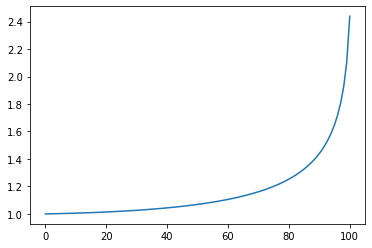

In [42]:
Hs_vec=np.zeros(len(lat_coords))
i=0
#calc Hs at each point in physical space
m_1D=IntervalMesh(n_sigma,omega_min,omega_max)
V_1D=FunctionSpace(m_1D, "CG",1)
i=0
for lat in lat_coords:
    print(lat)

    test1=my1DExpression(u,x=lat)
    Uy=interpolate(test1,V_1D)
    intUy=4*np.sqrt(assemble(Uy*dx))
    Hs_vec[i]=intUy
    i=i+1

#plot(Uy)
#print(intUy)
plt.plot(Hs_vec)


['YP', 'Hs', 'Dir', 'Dep', 'K', 'Cg', 'C']


Text(0.5, 1.0, 'Hs vs x')

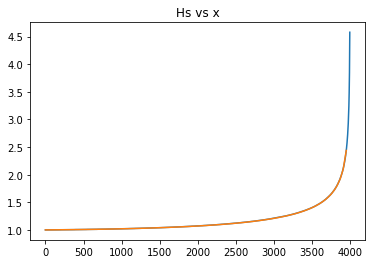

In [43]:
#attempt to read in analytic
fname='Shoaling_Analytic.txt'
f=open(fname,"r")
lines=f.readlines()
f.close()
column_names=lines[0].split()
print(column_names)
A=np.zeros((999,len(column_names))) #should be 1000, but last row is garbage
ctr=0
for line in lines[2:-1]:
    A[ctr,:]=line.split()
    ctr+=1

#now plot
plt.plot(A[:,0],A[:,1])
plt.plot(lat_coords[:],Hs_vec[:])
plt.title('Hs vs x')


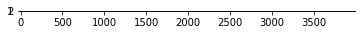